# LSTM: TF-IDF의 키워드를 통해 가사 한줄을 생성

## 1. Import Packages

In [ ]:
!nvidia-smi

Thu Apr 22 11:01:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    36W / 250W |    849MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 92kB 4.1MB/s 
     |████████████████████████████████| 460kB 49.5MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import os

In [4]:
from google.colab import drive

In [7]:
# from konlpy.tag import Okt
from gensim.models import Word2Vec, KeyedVectors
from gensim.models import FastText
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

In [36]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams, pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

## 2. Drive Mount

In [8]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
% cd /content/drive/MyDrive/Colab\ Notebooks/Project/Lyrics/2_LSTM/

/content/drive/MyDrive/Colab Notebooks/Project/Lyrics/2_LSTM


In [16]:
!ls -l

total 0


## 3. 데이터 로드

In [18]:
PATH = '../Data/2_LSTM_Ballard_Data.csv'

df = pd.read_csv(PATH)

In [19]:
df.head()

,Unnamed: 0,title,singer,lyrics
0,0,너희는 (Feat. 김광률),이은영,너희는 하나님의 택하신\n거룩하고 사랑스러운 자니 \n긍율과 자비와 \n겸손과 온유...
1,1,봄날은 간다 (Bonus Track),김윤아,눈을 감으면 문득 그리운 날의 기억 \n아직까지도 마음이 저려 오는 건 \n\n그건...
2,2,Going Home,김윤아,집으로 돌아가는 길에\n지는 햇살에 마음을 맡기고\n나는 너의 일을 떠올리며\n수많...
3,3,야상곡 (夜想曲),김윤아,바람이 부는 것은 더운 내 맘 삭여주려 \n계절이 다 가도록 나는 애만 태우네 \n...
4,4,길,김윤아,아무도 가르쳐 주지 않아\n이 길이 옳은지 다른 길로 가야 할지\n난 저길 저 끝에...


## 4. 데이터 전처리

- 결측치 제거/ 한글 외 제거

In [20]:
df.dropna(axis=0, inplace = True)

In [21]:
df['lyrics'] = df['lyrics'].str.replace('[^가-힣\n]' , ' ')

In [22]:
df.head()

,Unnamed: 0,title,singer,lyrics
0,0,너희는 (Feat. 김광률),이은영,너희는 하나님의 택하신\n거룩하고 사랑스러운 자니 \n긍율과 자비와 \n겸손과 온유...
1,1,봄날은 간다 (Bonus Track),김윤아,눈을 감으면 문득 그리운 날의 기억 \n아직까지도 마음이 저려 오는 건 \n\n그건...
2,2,Going Home,김윤아,집으로 돌아가는 길에\n지는 햇살에 마음을 맡기고\n나는 너의 일을 떠올리며\n수많...
3,3,야상곡 (夜想曲),김윤아,바람이 부는 것은 더운 내 맘 삭여주려 \n계절이 다 가도록 나는 애만 태우네 \n...
4,4,길,김윤아,아무도 가르쳐 주지 않아\n이 길이 옳은지 다른 길로 가야 할지\n난 저길 저 끝에...


In [23]:
lyrics = list(df['lyrics'])

- Tokenization

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lyrics)
vocab_size = len(tokenizer.word_index) + 1

print('단어 집합의 크기: %d' %vocab_size)

단어 집합의 크기: 21521


## 5. 훈련데이터 생성

In [25]:
%%time

sequences = list()

for lyric in lyrics:
  for line in lyric.split('\n'):
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)) :
      sequence = encoded[:i+1]
      sequences.append(sequence)

CPU times: user 538 ms, sys: 22.4 ms, total: 560 ms
Wall time: 563 ms


- 학습데이터 확인 및 시각화

In [28]:
print('학습에 사용할 샘플의 개수: %d' %len(sequences))
print('샘플의 최대 길이: ' , max(len(l) for l in sequences))
print('샘플의 평균 길이: ' , sum(map(len, sequences))/len(sequences))

학습에 사용할 샘플의 개수: 112336
샘플의 최대 길이:  215
샘플의 평균 길이:  7.6879717988890475


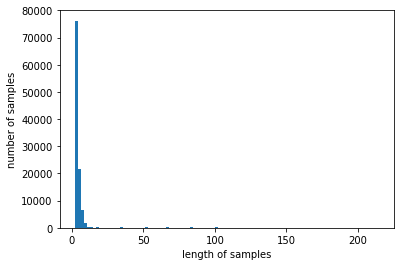

In [29]:
plt.hist([len(f) for f in sequences] , bins = 100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 대체로 0 ~ 25사이에 집중되어 있으므로 패딩사이즈를 30으로 조정

In [30]:
MAX_LEN = 30

In [31]:
sequences = pad_sequences(sequences, maxlen = MAX_LEN, padding = 'pre')

print(sequences)

[[   0    0    0 ...    0 4525 4526]
 [   0    0    0 ... 4525 4526 4527]
 [   0    0    0 ...    0 4528 1976]
 ...
 [ 279   29 3762 ... 1055 2344  149]
 [  29 3762 2419 ... 2344  149   96]
 [3762 2419   96 ...  149   96   10]]


In [32]:
np.shape(sequences)

(112336, 30)

- 각 샘플의 마지막 단어를 레이블로 분리

In [33]:
sequences = np.array(sequences)

X = sequences[:, :-1]
y = sequences[:, -1]

In [34]:
np.shape(X) , np.shape(y)

((112336, 29), (112336,))

- 레이블에 대해 원-핫 인코딩

In [35]:
y = to_categorical(y, num_classes=vocab_size)

## 6. Modeling

In [38]:
OUTPUT_DIM = 128

model = Sequential()

model.add(Embedding(vocab_size, output_dim = OUTPUT_DIM,
                    input_length = MAX_LEN -1))

model.add(LSTM(256))
model.add(Dense(vocab_size, activation = 'softmax'))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 29, 128)           2754688   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 21521)             5530897   
Total params: 8,679,825
Trainable params: 8,679,825
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

- Model Checkpoint, Early Stopping 옵션 지정

In [ ]:
weights_folder = '../Param/'

checkpoint = ModelCheckpoint(
    os.path.join(weights_folder, "2_LSTM_param.h5"),
    monitor = 'loss',
    verbose = 0,
    save_best_only = True,
    mode = 'min'
)

early_stopping = EarlyStopping(
    monitor = 'loss',
    restore_best_weights = True,
    patience = 10
)

callbacks_list = [checkpoint,
                 early_stopping]

- 모델 로드

In [43]:
model.load_weights(os.path.join(weights_folder, "2_LSTM_param.h5"))

## 7. Model Training

In [ ]:
# 2시간 14분 소요
%%time
history = model.fit(X, y, 
                    epochs = 200,
                    callbacks = callbacks_list,
                    batch_size = 128,
                    verbose = 1)

model.save('../Param/2_LSTM_param.h5')

Epoch 1/200
878/878 [==============================] - 59s 47ms/step - loss: 8.8702 - accuracy: 0.0117
Epoch 2/200
878/878 [==============================] - 43s 49ms/step - loss: 8.1357 - accuracy: 0.0201
Epoch 3/200
878/878 [==============================] - 40s 46ms/step - loss: 7.4077 - accuracy: 0.0364
Epoch 4/200
878/878 [==============================] - 40s 46ms/step - loss: 6.3758 - accuracy: 0.0865
Epoch 5/200
878/878 [==============================] - 40s 45ms/step - loss: 5.3343 - accuracy: 0.1756
Epoch 6/200
878/878 [==============================] - 39s 45ms/step - loss: 4.4557 - accuracy: 0.2787
Epoch 7/200
878/878 [==============================] - 39s 44ms/step - loss: 3.7259 - accuracy: 0.3793
Epoch 8/200
878/878 [==============================] - 39s 44ms/step - loss: 3.1427 - accuracy: 0.4670
Epoch 9/200
878/878 [==============================] - 39s 45ms/step - loss: 2.6459 - accuracy: 0.5434
Epoch 10/200
878/878 [==============================] - 39s 44ms/step - l

## 8. 결과 확인

### 1) 가사 생성함수 정의

In [44]:
def sentence_generation(model, tokenizer, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
  
  init_word = current_word # 처음 들어온 단어도 마지막에 같이 출력하기 위해 저장
  sentence = ''


  for _ in range(n):
    # 현재 단어에 대한 정수 인코딩
    encoded = tokenizer.texts_to_sequences([current_word])[0] 
    # 데이터에 대한 패딩
    encoded = pad_sequences([encoded], maxlen=MAX_LEN, padding='pre') 
    # 입력한 X(현재 단어)에 대해서 y를 예측하고 y(예측한 단어)를 result에 저장
    result = model.predict_classes(encoded, verbose=0)

    for word, index in tokenizer.word_index.items(): 
      if index == result: # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면
        break # 해당 단어가 예측 단어이므로 break
    current_word = current_word + ' '  + word # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
    sentence = sentence + ' ' + word # 예측 단어를 문장에 저장
  # for문이므로 이 행동을 다시 반복

  sentence = init_word + sentence
  
  return sentence

### 2) 가사 생성

- TF-IDF로 추출된 키워드로 가사 생성

In [46]:
keyword_list = ['아주',
                '다시',
                '사랑',
                '눈물',
                '순간',
                '내겐',
                '지금',
                '모습',
                '그대',
                '마음']

In [47]:
gene_lyrics = []
for keyword in keyword_list:
  gene_lyrics.append(sentence_generation(model, tokenizer, keyword, 8))

In [48]:
gene_lyrics

['아주 오래된 기억 저편에 인사 너의 눈 지나 같은',
 '다시 못 올 지난날을 난 꾸밈없이 영원히 간직하리 함께',
 '사랑 하나로 그 모든 비난을 이길 순 없겠죠 안',
 '눈물 흘리고 난 또 그만큼 그대를 채워요 일 그댄',
 '순간 내가 미쳤었는지 헛된 살것같은데 술 없이는 못 지나고',
 '내겐 너무 쉬울 것만 같은데 날 찾을 수 있니',
 '지금 이 순간 간절히 내가 바라는 한 가지 마',
 '모습 사랑해 줄 수 없는 그 날을 증발시켜줘 다시',
 '그대 내 품에 안겨 눈을 감아요 꿈 숨이 꿈',
 '마음 가득 기댈 곳이 필요할 때 있는데 네게 잊은']